In [3]:
import numpy as np
import matplotlib.pylab as plt

In [4]:
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

# Network definition
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


In [5]:
model = L.Classifier(MLP(64, 10))
#model.to_gpu()
device_num = -1

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)


# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train, 128)
test_iter = chainer.iterators.SerialIterator(test, 128,
                                             repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=device_num)

trainer = training.Trainer(updater, (100, 'epoch'), out="./result")
trainer.extend(extensions.Evaluator(test_iter, model, device=device_num))
trainer.extend(extensions.LogReport())
trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

trainer.extend(extensions.snapshot_object(model, 'snapshot_{.updater.epoch}'), trigger=(10, 'epoch'))

trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))



In [6]:
#trainer.run()

In [7]:
#chainer.serializers.load_npz("result/snapshot_100", model)

In [8]:
model = L.ResNet50Layers()

In [9]:
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

In [20]:
def re_normalization(input_array, rho, xp=np):
    input_array = input_array.array
    return chainer.Variable((input_array/xp.linalg.norm(input_array))*rho)

def normalize(x):
    return (x - x.min())/(x.max() - x.min())

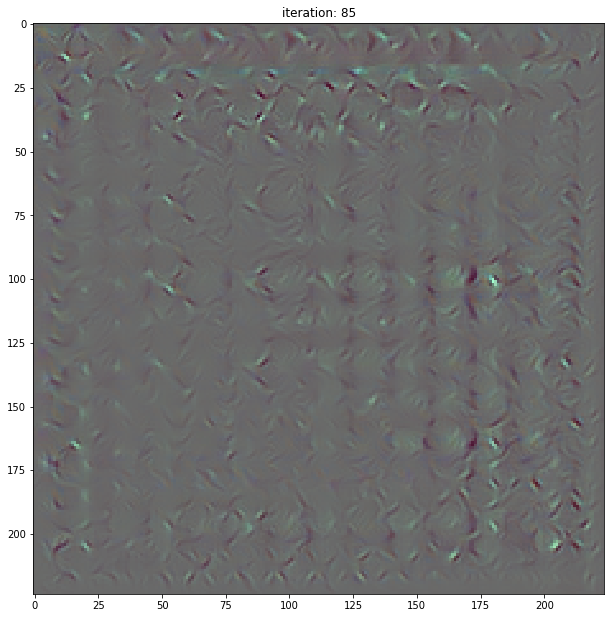

KeyboardInterrupt: 

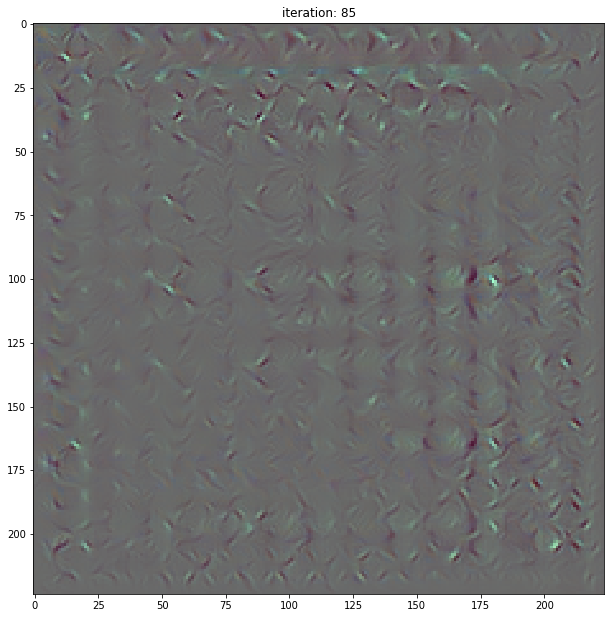

In [22]:
import numpy as cp
cp.random.seed(10)
#balse_line_img = cp.random.uniform(low=0, high=1*255, size=(224,224,3)).astype(cp.float32)
balse_line_img = cp.random.random(size=(224,224,3)).astype(cp.float32)
balse_line_img = chainer.links.model.vision.resnet.prepare(balse_line_img)[None]

input_img = chainer.Variable(balse_line_img.copy())
target_class = 10
learning_rate = 10
lambda_rate = 5
iteration = 100

activete_list = []
pred_list = []
fig = plt.figure()
upper_thresh = 0


i = -1
while True:
    i += 1
    if (i %20 == 0) & (i != 0):
        print(i)
    
    with chainer.using_config('train', False):
        input_img = re_normalization(input_img, rho=10, xp=cp)
        pred = model(input_img, layers=['fc6'])['fc6']
        pred_after_softmax = F.softmax(pred)[:, target_class]
        activate_value = pred[:, target_class]
        model.cleargrads()
        # maximum_activete = activate_value - lambda_rate*F.mean(F.square(input_img))
        maximum_activete = activate_value - lambda_rate*F.mean(F.square(input_img))
        maximum_activete.backward(retain_grad=True)
        
        if pred_after_softmax[0].array > 0.99:
            upper_thresh += 1
        
        pred_list.append(chainer.cuda.to_cpu(pred_after_softmax.array))
        activete_list.append(chainer.cuda.to_cpu(activate_value.array))
        input_img += learning_rate*input_img.grad
        
        if i % 5 == 0:
            clear_output(wait = True)
            fig.set_size_inches(18.5, 10.5)
            plt.title("iteration: " + str(i))
            plt.imshow(normalize(chainer.cuda.to_cpu(input_img[0].transpose(1,2,0).array)))
            display(fig)

        if upper_thresh >= 100:
            clear_output(wait = True)
            break

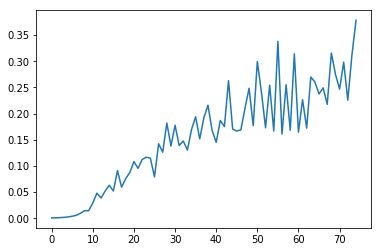

In [39]:
plt.plot(np.arange(len(pred_list)), pred_list)
plt.show()

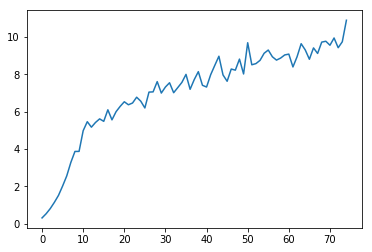

In [40]:
plt.plot(np.arange(len(activete_list)), activete_list)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


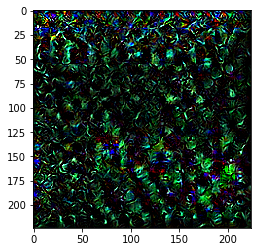

In [43]:
#plt.imshow(normalize(chainer.cuda.to_cpu(input_img[0].transpose(1,2,0).array)))
plt.imshow(chainer.cuda.to_cpu(input_img[0].transpose(1,2,0).array))
plt.show()

In [32]:
import pandas as pd

In [33]:
with open("/Users/furusawa_yoshihisa/Desktop/visualizing_with_deep_learning-master/imagenet1000_classification_list.txt") as f:
    data = f.readlines()

In [34]:
data[target_class]

" 10: 'brambling, Fringilla montifringilla',\n"